<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_top"><img src = "http://cocl.us/Pytorch_top" width = 950, align = "center">


<img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 200, align = "center">

<h1 align=center><font size = 5>Convolutional Neral Network Simple example </font></h1> 


<h3>Objective for this Notebook<h3>    
<h5> 1. Learn Convolutional Neral Network</h5>
<h5> 2. Define Softmax , Criterion function, Optimizer and Train the  Model</h5>    


# Table of Contents

In this lab, we will use a Convolutional Neral Networks to classify horizontal an vertical Lines 

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Helper functions </a></li>

<li><a href="#ref1"> Prepare Data </a></li>
<li><a href="#ref2">Convolutional Neral Network </a></li>
<li><a href="#ref3">Define Softmax , Criterion function, Optimizer and Train the  Model</a></li>
<li><a href="#ref4">Analyse Results</a></li>

<br>
<p></p>
Estimated Time Needed: <strong>25 min</strong>
</div>

<hr>


<a id="ref0"></a>

<h2 align=center>Helper functions </h2>


In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
torch.manual_seed(4)

function to plot out the parameters of the Convolutional layers  


In [3]:
def plot_channels(W):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

<code>show_data</code>: plot out data sample


In [4]:
def show_data(dataset,sample):

    plt.imshow(dataset.x[sample,0,:,:].numpy(),cmap='gray')
    plt.title('y='+str(dataset.y[sample].item()))
    plt.show()

create some toy data 


In [5]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self,N_images=100,offset=0,p=0.9, train=False):
        """
        p:portability that pixel is wight  
        N_images:number of images 
        offset:set a random vertical and horizontal offset images by a sample should be less than 3 
        """
        if train==True:
            np.random.seed(1)  
        
        #make images multiple of 3 
        N_images=2*(N_images//2)
        images=np.zeros((N_images,1,11,11))
        start1=3
        start2=1
        self.y=torch.zeros(N_images).type(torch.long)

        for n in range(N_images):
            if offset>0:
        
                low=int(np.random.randint(low=start1, high=start1+offset, size=1))
                high=int(np.random.randint(low=start2, high=start2+offset, size=1))
            else:
                low=4
                high=1
        
            if n<=N_images//2:
                self.y[n]=0
                images[n,0,high:high+9,low:low+3]= np.random.binomial(1, p, (9,3))
            elif  n>N_images//2:
                self.y[n]=1
                images[n,0,low:low+3,high:high+9] = np.random.binomial(1, p, (3,9))
           
        
        
        self.x=torch.from_numpy(images).type(torch.FloatTensor)
        self.len=self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self,index):      
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

<code>plot_activation</code>: plot out the activations of the Convolutional layers  


In [6]:
def plot_activations(A,number_rows= 1,name=""):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]
    
    
    print(n_activations)
    A_min=A.min().item()
    A_max=A.max().item()

    if n_activations==1:

        # Plot the image.
        plt.imshow(A[0,:], vmin=A_min, vmax=A_max, cmap='seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows)
        fig.subplots_adjust(hspace = 0.4)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(i+1))

                # Plot the image.
                ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)


In [7]:

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

<a id="ref1"></a>

<h2 align=center>Prepare Data </h2> 


Load the training dataset with 10000 samples 


In [8]:
N_images=10000
train_dataset=Data(N_images=N_images)

Load the testing dataset


In [9]:
validation_dataset=Data(N_images=1000,train=False)
validation_dataset

we can see the data type is long 


### Data Visualization


Each element in the rectangular  tensor corresponds to a number representing a pixel intensity  as demonstrated by  the following image.


We can print out the third label 


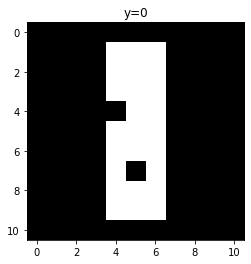

In [10]:
show_data(train_dataset,0)

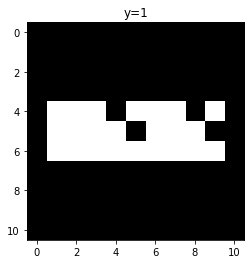

In [11]:
show_data(train_dataset,N_images//2+2)

we can plot the 3rd  sample 


<a id="ref3"></a>

### Build a Convolutional Neral Network Class


The input image is 11 x11, the following will change the size of the activations:

<ul>
<il>convolutional layer</il> 
</ul>
<ul>
<il>max pooling layer</il> 
</ul>
<ul>
<il>convolutional layer </il>
</ul>
<ul>
<il>max pooling layer </il>
</ul>

with the following parameters <code>kernel_size</code>, <code>stride</code> and <code> pad</code>.
We use the following  lines of code to change the image before we get tot he fully connected layer 


In [12]:
out=conv_output_shape((11,11), kernel_size=2, stride=1, pad=0, dilation=1)
print(out)
out1=conv_output_shape(out, kernel_size=2, stride=1, pad=0, dilation=1)
print(out1)
out2=conv_output_shape(out1, kernel_size=2, stride=1, pad=0, dilation=1)
print(out2)

out3=conv_output_shape(out2, kernel_size=2, stride=1, pad=0, dilation=1)
print(out3)

(10, 10)
(9, 9)
(8, 8)
(7, 7)


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [13]:
class CNN(nn.Module):
    def __init__(self,out_1=2,out_2=1):
        
        super(CNN,self).__init__()
        #first Convolutional layers 
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=2,padding=0)
        self.maxpool1=nn.MaxPool2d(kernel_size=2 ,stride=1)

        #second Convolutional layers
        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=2,stride=1,padding=0)
        self.maxpool2=nn.MaxPool2d(kernel_size=2 ,stride=1)
        #max pooling 

        #fully connected layer 
        self.fc1=nn.Linear(out_2*7*7,2)
        
    def forward(self,x):
        #first Convolutional layers
        x=self.cnn1(x)
        #activation function 
        x=torch.relu(x)
        #max pooling 
        x=self.maxpool1(x)
        #first Convolutional layers
        x=self.cnn2(x)
        #activation function
        x=torch.relu(x)
        #max pooling
        x=self.maxpool2(x)
        #flatten output 
        x=x.view(x.size(0),-1)
        #fully connected layer
        x=self.fc1(x)
        return x
    
    def activations(self,x):
        #outputs activation this is not necessary just for fun 
        z1=self.cnn1(x)
        a1=torch.relu(z1)
        out=self.maxpool1(a1)
        
        z2=self.cnn2(out)
        a2=torch.relu(z2)
        out=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out        

<a id="ref3"></a>

<h2> Define the Convolutional Neral Network Classifier , Criterion function, Optimizer and Train the  Model  </h2> 


There are 2 output channels for the first layer, and 1 outputs channel for the second layer 


In [14]:
model=CNN(2,1)

we can see the model parameters with the object 


In [15]:
model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


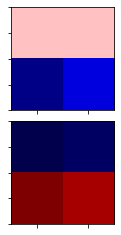

In [16]:

plot_channels(model.state_dict()['cnn1.weight'])


Loss function 


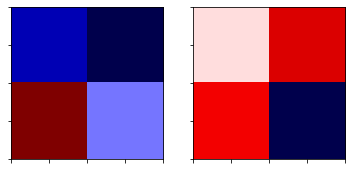

In [17]:
plot_channels(model.state_dict()['cnn2.weight'])

Define the loss function 


In [18]:
criterion=nn.CrossEntropyLoss()

 optimizer class 


In [19]:
learning_rate=0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Define the optimizer class 


In [20]:

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=10)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=20)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [21]:
n_epochs=10
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
cost=0
#n_epochs
for epoch in range(n_epochs):
    cost=0    
    for x, y in train_loader:
      

        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        cost+=loss.item()
    cost_list.append(cost)
        
        
    correct=0
    #perform a prediction on the validation  data  
    for x_test, y_test in validation_loader:

        z=model(x_test)
        _,yhat=torch.max(z.data,1)

        correct+=(yhat==y_test).sum().item()
        

    accuracy=correct/N_test

    accuracy_list.append(accuracy)
    



#### <a id="ref3"></a>

<h2 align=center>Analyse Results</h2> 


Plot the loss and accuracy on the validation data:


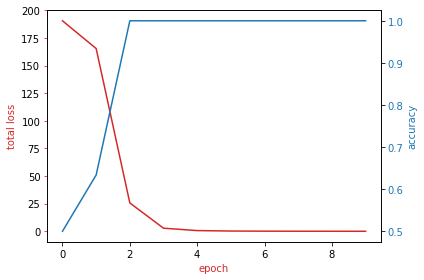

In [35]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 


In [36]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3439,  0.4699],
          [-0.1493, -0.2304]]],


        [[[-0.4155, -0.2465],
          [ 0.9437,  0.8787]]]])

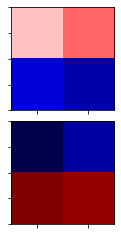

In [37]:
plot_channels(model.state_dict()['cnn1.weight'])

In [38]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3439,  0.4699],
          [-0.1493, -0.2304]]],


        [[[-0.4155, -0.2465],
          [ 0.9437,  0.8787]]]])

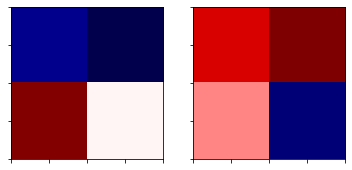

In [39]:
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 


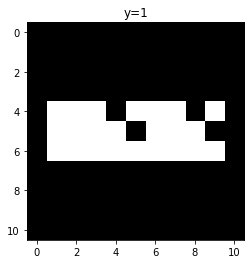

In [40]:
show_data(train_dataset,N_images//2+2)

Determine the activations 


In [41]:
out=model.activations(train_dataset[N_images//2+2][0].view(1,1,11,11))
out=model.activations(train_dataset[0][0].view(1,1,11,11))

Plot them out


2


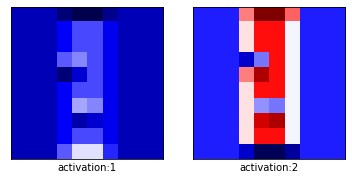

In [42]:
plot_activations(out[0],number_rows=1,name=" feature map")
plt.show()


1


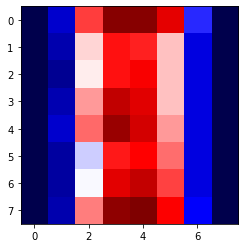

In [43]:
plot_activations(out[2],number_rows=1,name="2nd feature map")
plt.show()

1


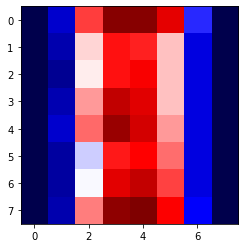

In [44]:
plot_activations(out[3],number_rows=1,name="first feature map")
plt.show()

we save the output of the activation after flattening  


In [45]:
out1=out[4][0].detach().numpy()

we can do the same for a sample  where y=0 


In [46]:
out0=model.activations(train_dataset[100][0].view(1,1,11,11))[4][0].detach().numpy()
out0

array([0.72394097, 1.7302998 , 2.3079784 , 2.3079784 , 2.3079784 ,
       1.9456702 , 0.93931115, 0.5969025 , 1.332521  , 1.8642553 ,
       1.8642553 , 1.8501743 , 1.5478183 , 0.7764221 , 0.5969025 ,
       1.332521  , 1.8642553 , 1.8642553 , 1.8501743 , 1.6339116 ,
       0.7764221 , 0.5969025 , 1.3431224 , 1.9524441 , 2.075549  ,
       2.075549  , 1.7210199 , 0.7764221 , 0.5969025 , 1.4195564 ,
       2.018051  , 2.084281  , 2.084281  , 1.7210199 , 0.7764221 ,
       0.5969025 , 1.4195564 , 2.018051  , 2.084281  , 2.084281  ,
       1.6349267 , 0.7764221 , 0.63690555, 1.475388  , 1.965958  ,
       1.965958  , 1.965958  , 1.6906853 , 0.8522027 ], dtype=float32)

Text(0, 0.5, 'Activation')

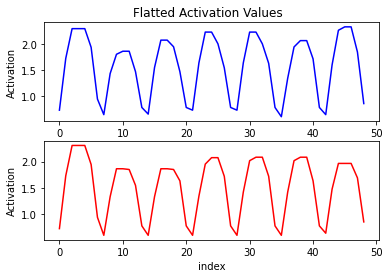

In [47]:
plt.subplot(2, 1, 1)
plt.plot( out1, 'b')
plt.title('Flatted Activation Values  ')
plt.ylabel('Activation')
plt.xlabel('index')
plt.subplot(2, 1, 2)
plt.plot(out0, 'r')
plt.xlabel('index')
plt.ylabel('Activation')

### About the Authors:

[Joseph Santarcangelo](https://www.linkedin.com/in/joseph-s-50398b136?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork-20647811&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](https://www.linkedin.com/in/michelleccarey?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork-20647811&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ) 


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Srishti    | Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


  <hr>
Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).
